In [240]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb
 


In [241]:

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [242]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez



Note that the test and train data have the same format except the test data doesn't have a transported column.   I am going to add a 'Train' column to make seperating these easier and then later join them up.

In [243]:
train_data['Train']= True
test_data['Train'] = False

all_data = pd.concat([train_data,test_data]).reset_index(drop=True)

## Examine and PreProcess data

Missing data?

In [244]:
all_data.apply(lambda x:np.sum(x.isna()))/all_data.count()

PassengerId     0.000000
HomePlanet      0.022709
CryoSleep       0.024487
Cabin           0.023597
Destination     0.021582
Age             0.021260
VIP             0.023355
RoomService     0.020697
FoodCourt       0.022790
ShoppingMall    0.024163
Spa             0.022387
VRDeck          0.021099
Name            0.023193
Transported     0.492005
Train           0.000000
dtype: float64

Each column has about 2% missing data.

In [245]:
def plot_transported_rate(data, col):
    survival  = data[["Transported",col]].groupby(col).mean().reset_index()
    sns.barplot(data=survival,x=col, y='Transported')

### Home Planet

<AxesSubplot:xlabel='HomePlanet', ylabel='Count'>

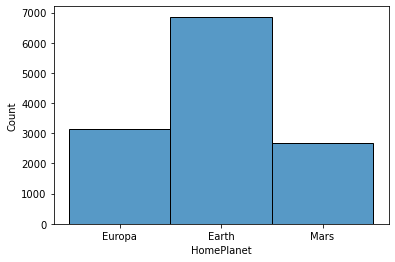

In [246]:
sns.histplot(all_data['HomePlanet'])

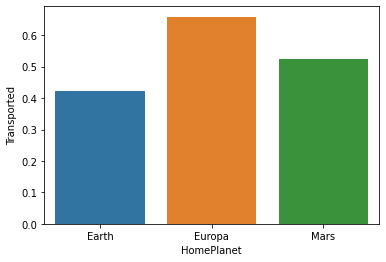

In [247]:
plot_transported_rate(all_data[all_data["Train"]], "HomePlanet")

Ok home planet is most commonly earth, so we will fill in Earth for missing ones. We also want to make this Categorical. 

In [248]:
all_data.loc[all_data.HomePlanet.isna(),"HomePlanet"] = "Earth"

In [249]:
all_data = all_data.join(pd.get_dummies(all_data["HomePlanet"], prefix="HP", drop_first=True)) # Earth is baseline

### Cryosleep

In [250]:
all_data['CryoSleep'] = all_data['CryoSleep'].astype('category') 

In [251]:
all_data['CryoSleep'].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [252]:
all_data.loc[all_data["CryoSleep"].isna(),"CryoSleep"] = False 

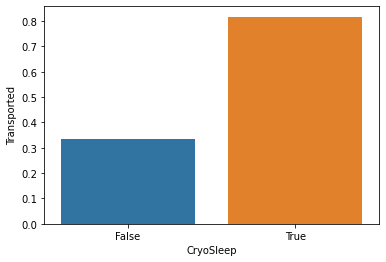

In [253]:
plot_transported_rate(all_data[all_data["Train"]], "CryoSleep")

Cryosleep is a STRONG predictor of being transported

### Cabin 

This one is a bit tricky as there is clearly useful information from this but we are going to have to parse it out abit. First look at all the non-na.  REMEMBER DO NOT combine these with the original data yet.

In [254]:
cabin_temp = all_data.loc[all_data.Cabin.notna(),["Cabin","Transported", "Train"]].reset_index(drop=True)

cabin_dat =pd.DataFrame(cabin_temp["Cabin"].map(lambda x: x.split('/')).to_list(), columns= ["Class","Number","PS"])

cabin_comb = cabin_temp.join(cabin_dat)
cabin_comb.head()

,Cabin,Transported,Train,Class,Number,PS
0,B/0/P,False,True,B,0,P
1,F/0/S,True,True,F,0,S
2,A/0/S,False,True,A,0,S
3,A/0/S,False,True,A,0,S
4,F/1/S,True,True,F,1,S


In [255]:
cabin_comb.apply(lambda x:np.sum(x.isna()))

Cabin             0
Transported    4177
Train             0
Class             0
Number            0
PS                0
dtype: int64

<AxesSubplot:xlabel='Class', ylabel='Count'>

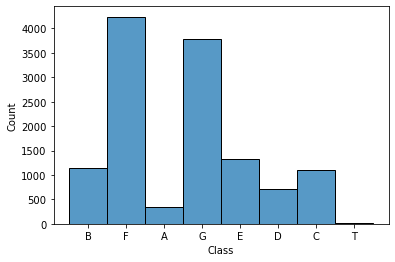

In [256]:
sns.histplot(cabin_comb["Class"])

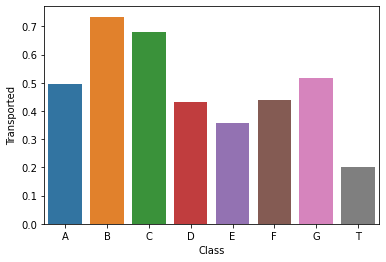

In [257]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]], "Class")

Class seems to effect transport rate

In [258]:
cabin_comb["PS"].describe()   #Port Starboard?

count     12671
unique        2
top           S
freq       6381
Name: PS, dtype: object

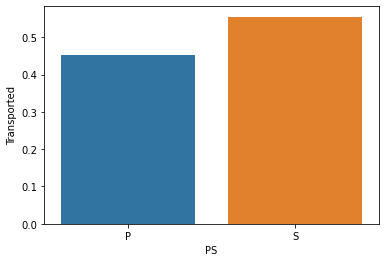

In [259]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]] , "PS")

Hmm.. port starboard might matter too!  Not sure how do deal with the missing values in this event.  Possibly add a third category = missing

In [260]:
cabin_comb["Number"].astype("int").describe()

count    12671.000000
mean       603.601926
std        512.891926
min          0.000000
25%        170.000000
50%        431.000000
75%       1008.000000
max       1894.000000
Name: Number, dtype: float64

In [261]:
cabin_comb["Number"] = cabin_comb["Number"].astype("int")

In [262]:
cabin_comb["Num_Cat"] = pd.qcut(cabin_comb["Number"],8)

In [263]:
cabin_comb.head()

,Cabin,Transported,Train,Class,Number,PS,Num_Cat
0,B/0/P,False,True,B,0,P,"(-0.001, 79.0]"
1,F/0/S,True,True,F,0,S,"(-0.001, 79.0]"
2,A/0/S,False,True,A,0,S,"(-0.001, 79.0]"
3,A/0/S,False,True,A,0,S,"(-0.001, 79.0]"
4,F/1/S,True,True,F,1,S,"(-0.001, 79.0]"


In [264]:
cabin_comb["Num_Cat"].value_counts()

(-0.001, 79.0]      1599
(170.0, 267.0]      1591
(682.75, 1008.0]    1588
(1338.0, 1894.0]    1583
(431.0, 682.75]     1582
(1008.0, 1338.0]    1581
(267.0, 431.0]      1574
(79.0, 170.0]       1573
Name: Num_Cat, dtype: int64

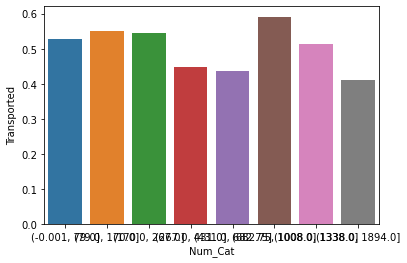

In [265]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]], "Num_Cat")

Seems like the number matters... but for a first pass I will skip on it.  Ok so here is what we will do for this case: 

* Split out all the no-na values .  drop cabin number. 

* Set class = 'F" and PS = 'Uknown"  for na's

In [266]:
def get_class_ps(x):
    if pd.isna(x):
        return ['F','Unknown']
    else:
        (c,num,ps) = x.split('/')
        return [c,ps]

cabin_dat = pd.DataFrame(all_data["Cabin"].map(get_class_ps).to_list(), columns= ["Class","PS"])

 

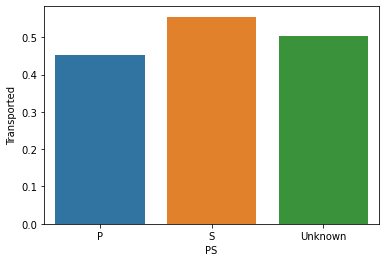

In [267]:
all_data = all_data.join(cabin_dat)
plot_transported_rate(all_data[all_data["Train"]] , "PS")

In [268]:
all_data["PS"].value_counts()

S          6381
P          6290
Unknown     299
Name: PS, dtype: int64

The 300 'Uknown" are probably not going to be worth much in training, but i will leave it this way. For the rest I will replace with mode or mean .

In [269]:
all_data = all_data.join(pd.get_dummies(all_data["PS"],prefix="SIDE", drop_first=True) )
all_data = all_data.join(pd.get_dummies(all_data["Class"], prefix="Class")).drop(columns="Class_F") #dropping most common class to use as base
all_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,PS,SIDE_S,SIDE_Unknown,Class_A,Class_B,Class_C,Class_D,Class_E,Class_G,Class_T
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,P,0,0,0,1,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,S,1,0,0,0,0,0,0,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,S,1,0,1,0,0,0,0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,S,1,0,1,0,0,0,0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,S,1,0,0,0,0,0,0,0,0


In [270]:
all_data = all_data.drop(columns = ["HomePlanet","Cabin","Class","PS"])
all_data.head()

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,HP_Mars,SIDE_S,SIDE_Unknown,Class_A,Class_B,Class_C,Class_D,Class_E,Class_G,Class_T
0,0001_01,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0002_01,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,0,1,0,0,0,0,0,0,0,0
2,0003_01,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,0,1,0,1,0,0,0,0,0,0
3,0003_02,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,0,1,0,1,0,0,0,0,0,0
4,0004_01,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,0,1,0,0,0,0,0,0,0,0


Note that Class A is baseline, as is Port

### Destination

<AxesSubplot:xlabel='Destination', ylabel='Count'>

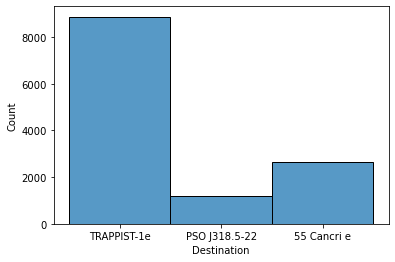

In [271]:
sns.histplot(all_data["Destination"])

In [272]:
all_data.loc[all_data["Destination"].isna(), "Destination"] = all_data["Destination"].mode()
all_data["Destination"] = all_data["Destination"].astype("category")

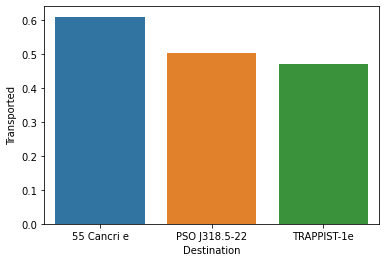

In [273]:
plot_transported_rate(all_data[all_data["Train"]] , "Destination")

In [274]:
all_data = all_data.join(pd.get_dummies(all_data["Destination"], prefix="Dest")).drop(columns = ["Destination",'Dest_TRAPPIST-1e'])
all_data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,SIDE_Unknown,Class_A,Class_B,Class_C,Class_D,Class_E,Class_G,Class_T,Dest_55 Cancri e,Dest_PSO J318.5-22
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,0,1,0,0,0,0,0,0,0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0,0,0,0,0,0,0,0,0,0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,0,1,0,0,0,0,0,0,0,0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,0,1,0,0,0,0,0,0,0,0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,0,0,0,0,0,0,0,0,0,0


TRAPPIST-1e is baseline here.

### Age

In [275]:
all_data.Age.describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [276]:
all_data.loc[all_data["Age"].isna(),"Age"] = np.mean(all_data.Age)

In [277]:
all_data["Age_Cat"]  = pd.cut(all_data["Age"],[0,12,21,30,60,100])

In [278]:
all_data["Age_Cat"].value_counts()

(30, 60]     4715
(21, 30]     3808
(12, 21]     2963
(0, 12]       897
(60, 100]     327
Name: Age_Cat, dtype: int64

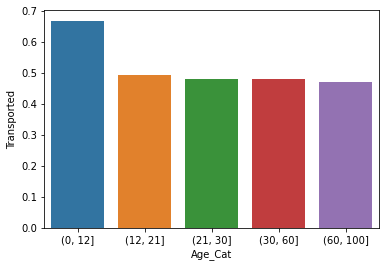

In [279]:
plot_transported_rate(all_data[all_data["Train"]] , "Age_Cat")

In [280]:
mean_age = all_data["Age"].mean()
std_age = all_data["Age"].std()
all_data["Age_Std"] = (all_data["Age"] - mean_age)/std_age
(mean_age,std_age)

(28.77196850393714, 14.236709921289403)

In [281]:
all_data = all_data.drop(columns=["Name", "Age","Age_Cat"])

### VIP

In [282]:
all_data.VIP.value_counts()

False    12401
True       273
Name: VIP, dtype: int64

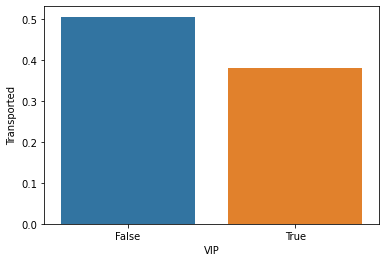

In [283]:
all_data.loc[all_data["VIP"].isna(),"VIP"] = False
plot_transported_rate(all_data[all_data["Train"]] , "VIP")

### Spending

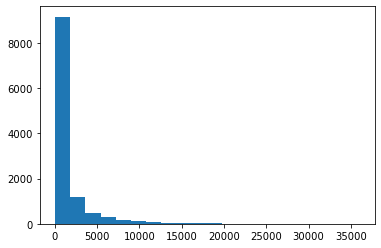

In [284]:
plt.hist(all_data["VRDeck"]+all_data["Spa"]+all_data["RoomService"]+all_data["ShoppingMall"]+all_data["FoodCourt"],bins=20);

In [285]:
spend = all_data.loc[:,"RoomService":"VRDeck"]
spend.mode()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0


Most commonof all these is zero spend

In [286]:
for x in spend.columns:
    all_data.loc[all_data[x].isna(),x] = 0.0

Ok lets see if any of these are useful in isolation

In [287]:
temp = all_data[spend.columns.append(pd.Index(['Transported','Train']))].reset_index(drop=True)
for x in spend.columns:
    temp[x + "_cut"] = pd.cut(temp[x],[-1,0,1000,2000,5000,10000,20000,40000])


In [288]:
temp.max()

RoomService                14327.0
FoodCourt                  29813.0
ShoppingMall               23492.0
Spa                        22408.0
VRDeck                     24133.0
Transported                   True
Train                         True
RoomService_cut     (10000, 20000]
FoodCourt_cut       (20000, 40000]
ShoppingMall_cut    (20000, 40000]
Spa_cut             (20000, 40000]
VRDeck_cut          (20000, 40000]
dtype: object

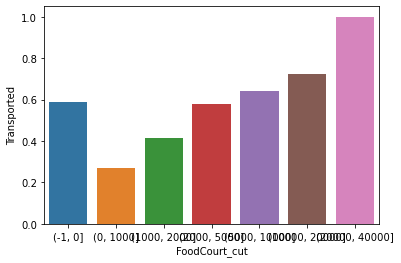

In [289]:
plot_transported_rate(temp[temp["Train"]] , "FoodCourt_cut")

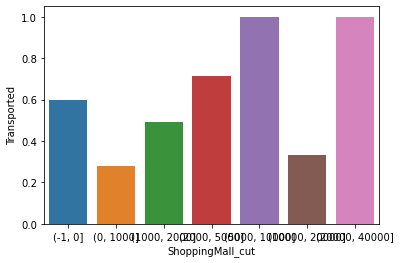

In [290]:
plot_transported_rate(temp[temp["Train"]] , "ShoppingMall_cut")

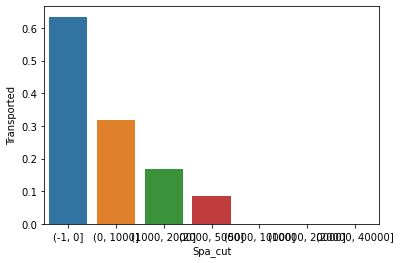

In [291]:
plot_transported_rate(temp[temp["Train"]] , "Spa_cut")

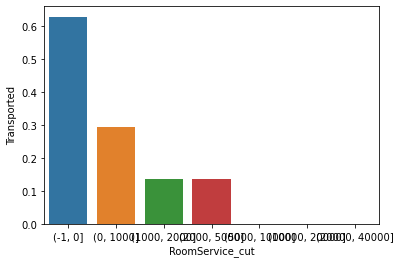

In [292]:
plot_transported_rate(temp[temp["Train"]] , "RoomService_cut")

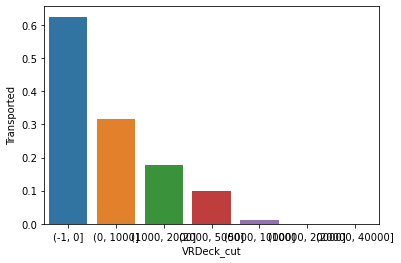

In [293]:
plot_transported_rate(temp[temp["Train"]] , "VRDeck_cut")

In [294]:
temp["VRDeck_cut"].value_counts()

(-1, 0]           8520
(0, 1000]         3525
(1000, 2000]       437
(2000, 5000]       323
(5000, 10000]      121
(10000, 20000]      41
(20000, 40000]       3
Name: VRDeck_cut, dtype: int64

In [295]:
temp["RoomService_cut"].value_counts()

(-1, 0]           8566
(0, 1000]         3488
(1000, 2000]       616
(2000, 5000]       264
(5000, 10000]       34
(10000, 20000]       2
(20000, 40000]       0
Name: RoomService_cut, dtype: int64

In [296]:
temp["Spa_cut"].value_counts()

(-1, 0]           8219
(0, 1000]         3818
(1000, 2000]       443
(2000, 5000]       344
(5000, 10000]      110
(10000, 20000]      35
(20000, 40000]       1
Name: Spa_cut, dtype: int64

For a first cut, I am going to only use the three luxury spending combined.  Not sure how well it will work with so many zeros.

In [297]:
all_data["LuxurySpend"] = all_data["Spa"] + all_data["VRDeck"] + all_data["RoomService"]

In [298]:
(all_data["LuxurySpend"].max(), all_data["LuxurySpend"].min())

(28600.0, 0.0)

In [299]:
cuts = list(range(-1000,30000,1000))
len(cuts)

31

In [300]:
all_data["LuxurySpend_cut"] = pd.cut(all_data["LuxurySpend"],cuts)

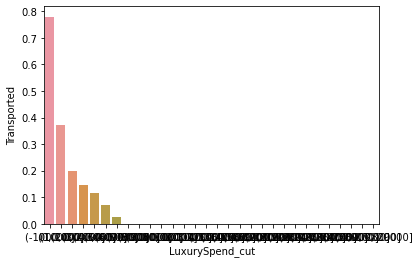

In [301]:
plot_transported_rate(all_data[all_data["Train"]] , "LuxurySpend_cut")

Looks exponential try a log

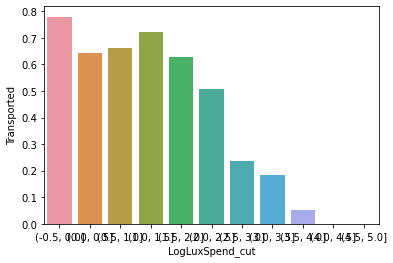

In [302]:
all_data["LogLuxSpend"] = np.log10(all_data["LuxurySpend"]+1)  
all_data["LogLuxSpend_cut"] = pd.cut(all_data["LogLuxSpend"],[-0.5,0,.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plot_transported_rate(all_data[all_data["Train"]] , "LogLuxSpend_cut")

<AxesSubplot:xlabel='LogLuxSpend', ylabel='Count'>

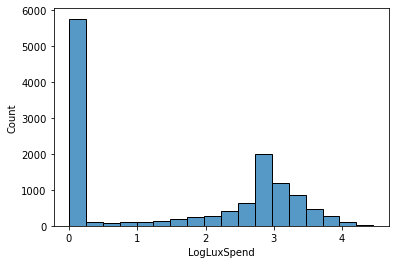

In [303]:
sns.histplot(all_data["LogLuxSpend"])

In [304]:
all_data["LogLuxSpend"].mean()

1.53878035483516

Seems like a strong predictor on a sort of log scale

In [305]:
all_data.drop(columns=["RoomService", "FoodCourt", "ShoppingMall","Spa", "VRDeck", "LuxurySpend_cut","LogLuxSpend_cut"], inplace=True)

Check we took care of all NA 's except of course in the test data

In [306]:
all_data.apply(lambda x:np.sum(x.isna()))

PassengerId              0
CryoSleep                0
VIP                      0
Transported           4277
Train                    0
HP_Europa                0
HP_Mars                  0
SIDE_S                   0
SIDE_Unknown             0
Class_A                  0
Class_B                  0
Class_C                  0
Class_D                  0
Class_E                  0
Class_G                  0
Class_T                  0
Dest_55 Cancri e         0
Dest_PSO J318.5-22       0
Age_Std                  0
LuxurySpend              0
LogLuxSpend              0
dtype: int64

### Re-devide data

In [307]:
# Now split it back out

test_data = all_data[~all_data["Train"]].drop(columns="Train").reset_index(drop=True)

train_data = all_data[all_data["Train"]].drop(columns="Train").reset_index(drop=True)


## Try to fit a logistic regression

In [308]:
predictors = train_data.drop(columns = [ "PassengerId", "Transported","LuxurySpend"]).columns.to_list()
predictors

['CryoSleep',
 'VIP',
 'HP_Europa',
 'HP_Mars',
 'SIDE_S',
 'SIDE_Unknown',
 'Class_A',
 'Class_B',
 'Class_C',
 'Class_D',
 'Class_E',
 'Class_G',
 'Class_T',
 'Dest_55 Cancri e',
 'Dest_PSO J318.5-22',
 'Age_Std',
 'LogLuxSpend']

In [309]:
COORDS = {"predictors": predictors, "obs_idx": train_data.index}

with pm.Model(coords=COORDS) as m_full:
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=10, dims="predictors")
     
    pred = pm.ConstantData("preds", train_data[predictors], dims = ("obs_ix", 'predictors'))

 
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu), dims="obs_idx")


    y = pm.Bernoulli("y",p=p, observed=train_data["Transported"], dims="obs_idx")

In [310]:
with m_full:
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 185 seconds.


In [311]:
az.summary(idata, var_names=['slopes','intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],0.169,0.092,-0.003,0.339,0.001,0.000,20048.0,15474.0,1.0
slopes[VIP],-0.154,0.186,-0.503,0.189,0.001,0.001,34247.0,14337.0,1.0
slopes[HP_Europa],1.114,0.169,0.793,1.433,0.002,0.001,10426.0,13508.0,1.0
slopes[HP_Mars],0.259,0.090,0.088,0.426,0.001,0.000,20631.0,17146.0,1.0
slopes[SIDE_S],0.539,0.055,0.434,0.640,0.000,0.000,33744.0,14895.0,1.0
slopes[SIDE_Unknown],-0.307,0.204,-0.695,0.073,0.001,0.001,28851.0,16175.0,1.0
slopes[Class_A],-0.612,0.238,-1.052,-0.163,0.002,0.001,12975.0,15222.0,1.0
slopes[Class_B],0.134,0.200,-0.243,0.506,0.002,0.001,11157.0,14649.0,1.0
slopes[Class_C],0.441,0.194,0.073,0.802,0.002,0.001,10796.0,13994.0,1.0
slopes[Class_D],-0.046,0.148,-0.327,0.226,0.001,0.001,17786.0,16070.0,1.0


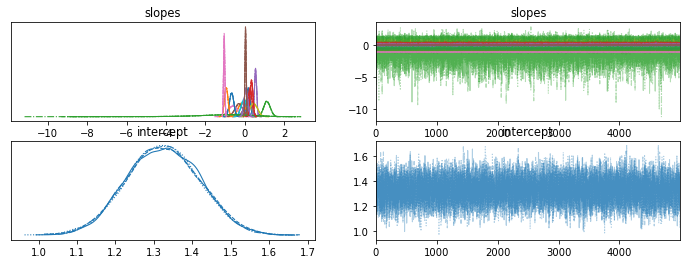

In [312]:
az.plot_trace(idata, var_names=['slopes','intercept']);

From the above it looks like VIP and Age are not very strong predictors so we will drop them as well as SIDE

In [313]:
predictors = train_data.drop(columns = [ "VIP", "Age_Std", "SIDE_S", "SIDE_Unknown", "PassengerId", "Transported","LuxurySpend"]).columns.to_list()
predictors

['CryoSleep',
 'HP_Europa',
 'HP_Mars',
 'Class_A',
 'Class_B',
 'Class_C',
 'Class_D',
 'Class_E',
 'Class_G',
 'Class_T',
 'Dest_55 Cancri e',
 'Dest_PSO J318.5-22',
 'LogLuxSpend']

In [314]:
COORDS = {"predictors": predictors, "obs_idx": train_data.index}

with pm.Model(coords=COORDS) as m_2:
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=10, dims="predictors")
     
    pred = pm.ConstantData("preds", train_data[predictors], dims = ("obs_ix", 'predictors'))

 
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu), dims="obs_idx")


    y = pm.Bernoulli("y",p=p, observed=train_data["Transported"], dims="obs_idx")

    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 181 seconds.


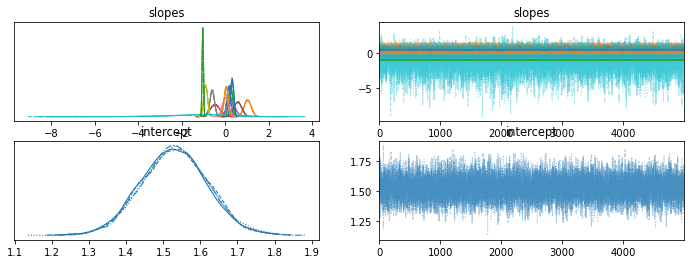

In [315]:

az.plot_trace(idata2, var_names=['slopes','intercept']);

In [316]:
az.summary(idata2, var_names=['slopes','intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],0.166,0.090,0.001,0.337,0.001,0.001,16845.0,14825.0,1.0
slopes[HP_Europa],1.027,0.163,0.729,1.334,0.002,0.001,10731.0,12141.0,1.0
slopes[HP_Mars],0.248,0.089,0.085,0.415,0.001,0.000,19335.0,16371.0,1.0
slopes[Class_A],-0.473,0.226,-0.912,-0.056,0.002,0.001,12872.0,15427.0,1.0
slopes[Class_B],0.261,0.190,-0.093,0.615,0.002,0.001,11978.0,14236.0,1.0
slopes[Class_C],0.570,0.185,0.226,0.919,0.002,0.001,11609.0,12845.0,1.0
slopes[Class_D],0.015,0.144,-0.250,0.291,0.001,0.001,14532.0,15005.0,1.0
slopes[Class_E],-0.603,0.104,-0.792,-0.401,0.001,0.001,19821.0,14363.0,1.0
slopes[Class_G],-0.904,0.085,-1.060,-0.739,0.001,0.000,17767.0,15196.0,1.0
slopes[Class_T],-1.194,1.425,-3.873,1.376,0.011,0.011,20358.0,10009.0,1.0


In [320]:
az.loo(idata2)

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 posterior samples and 8693 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4193.12    49.27
p_loo       13.82        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     8692  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%

Ok now just looking at only the MOST significant ones, especially for purposes of the BayesRules Homework

In [321]:
predictors =  ["HP_Europa","HP_Mars","LogLuxSpend"]
train_data[predictors]

,HP_Europa,HP_Mars,LogLuxSpend
0,1,0,0.000000
1,0,0,2.846955
2,1,0,3.833020
3,1,0,3.546913
4,0,0,2.940018
...,...,...,...
8688,1,0,3.235023
8689,0,0,0.000000
8690,0,0,0.301030
8691,1,0,3.554973


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 76 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[HP_Europa],1.699,0.073,1.564,1.840,0.001,0.0,15309.0,14876.0,1.0
slopes[HP_Mars],0.629,0.071,0.500,0.766,0.001,0.0,15554.0,13460.0,1.0
slopes[LogLuxSpend],-0.964,0.020,-1.002,-0.927,0.000,0.0,14490.0,13261.0,1.0
intercept,1.009,0.043,0.927,1.091,0.000,0.0,14106.0,13208.0,1.0


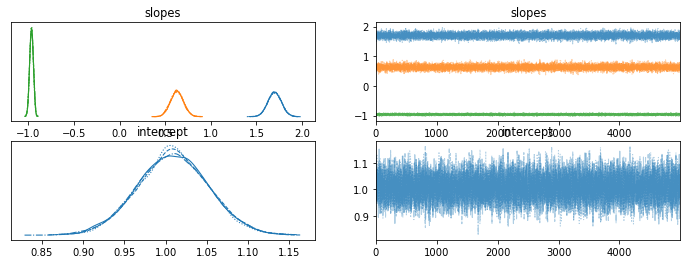

In [322]:
COORDS = {"predictors": predictors, "obs_idx": train_data.index}

with pm.Model(coords=COORDS) as m_3:
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=10, dims="predictors")
     
    pred = pm.ConstantData("preds", train_data[predictors], dims = ("obs_ix", 'predictors'))

 
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu), dims="obs_idx")


    y = pm.Bernoulli("y",p=p, observed=train_data["Transported"], dims="obs_idx")

    idata3 = pm.sample(5000)

az.plot_trace(idata3, var_names=['slopes','intercept']);
az.summary(idata3, var_names=['slopes','intercept'])

In [323]:
az.loo(idata3)

Computed from 20000 posterior samples and 8693 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4281.83    49.02
p_loo        3.68        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     8693  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<AxesSubplot:xlabel='y / y'>

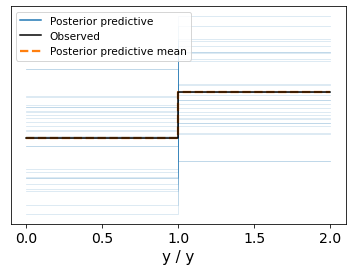

In [325]:
with m_3:
    pm.sample_posterior_predictive(idata3, extend_inferencedata=True)
az.plot_ppc(idata3, num_pp_samples = 30)

In [384]:
pred = np.mean(idata3.posterior_predictive.y.values.reshape(20000,-1) ,axis=0)>0.5

In [385]:
confusion = pd.DataFrame({'train' : train_data['Transported'], 'pred' : pred})
confusion['Count' ] =1
confusion.groupby(["train","pred"]).count().unstack()

Count      
pred  False  True
train            
False  3368   947
True   1041  3337

In [386]:
np.mean(pred == train_data['Transported'])

0.7713102496261359

In [387]:
with m_full:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

pred = np.mean(idata.posterior_predictive.y.values.reshape(20000,-1) ,axis=0)>0.5
confusion = pd.DataFrame({'train' : train_data['Transported'], 'pred' : pred})
confusion['Count' ] =1
confusion.groupby(["train","pred"]).count().unstack()

Count      
pred  False  True
train            
False  3353   962
True    957  3421

In [388]:
np.mean(pred == train_data['Transported'])

0.7792476705395146

# Apply best model to test data.